#  Applied Machine Learning 

## Homework 3: Preprocessing 


## Table of Contents

- [Instructions](#si)
- [Introduction](#in)
- [Exercise 1: Introducing the dataset](#1)
- [Exercise 2: Exploratory data analysis (EDA)](#2)
- [Exercise 3: Preprocessing](#3)
- [Exercise 4: Building models](#4)
- [Exercise 5: Evaluating on the test set](#5)

## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [2]:
census_df = pd.read_csv("adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data Splitting 
rubric={points:4}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (60%) and `test_df` (40%) with `random_state = 42`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here I'm using 60%/40% split because this is kind of a big dataset for a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!_

In [3]:
train_df,test_df = train_test_split(census_df,train_size=0.60,test_size=0.40,random_state=42)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [4]:
train_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico,<=50K
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States,<=50K
27652,25,Local-gov,109526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,38,United-States,<=50K
13941,23,Private,131275,HS-grad,9,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
31384,27,Private,193122,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
# count '?' in each column 

def count_value_in_df(df,value):
    return (df == value).sum()



In [6]:
#count specific value column wise
count_value_in_df(train_df,'?')

age                  0
workclass         1108
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1112
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     349
income               0
dtype: int64

In [7]:
train_df_nan  = train_df.replace('?',np.nan)

In [8]:
# after replace ? wit NAN

count_value_in_df(train_df_nan,'?')

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features
rubric={points:10}

**Your tasks:**

1. Examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, use the `include="all"` argument to show summary statistics of all  features.
2. Visualize the histograms of numeric features. 
3. From the visualizations, which features seem relevant for the given prediction task?

> Note: (Optional) If you're feeling excited about this you are welcome to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA. 

In [8]:
train_df_nan.isnull().sum()

age                  0
workclass         1108
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1112
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     349
income               0
dtype: int64

In [10]:
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       18428 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      18424 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19187 non-null  object
 14  income          19536 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.4+ MB


In [11]:
train_df_nan.describe()
# train_df_nan.describe(include='all')

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,19536.000000,1.953600e+04,19536.000000,19536.000000,19536.000000,19536.000000
mean,38.592547,1.892662e+05,10.084767,1090.443540,86.537162,40.532606
std,13.638971,1.049020e+05,2.580723,7449.700833,402.395668,12.406636
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.177670e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782835e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.368860e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
numeric_columns = ['age','fnlwgt','education.num','capital.gain','capital.loss','hours.per.week']

In [13]:
train_df_nan[train_df_nan.income == '<=50K']

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico,<=50K
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States,<=50K
27652,25,Local-gov,109526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,38,United-States,<=50K
13941,23,Private,131275,HS-grad,9,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
31384,27,Private,193122,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,45,Federal-gov,45891,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Male,0,0,42,United-States,<=50K
11964,24,Private,172612,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
21575,53,Private,192386,HS-grad,9,Separated,Transport-moving,Unmarried,White,Male,0,0,45,United-States,<=50K
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K


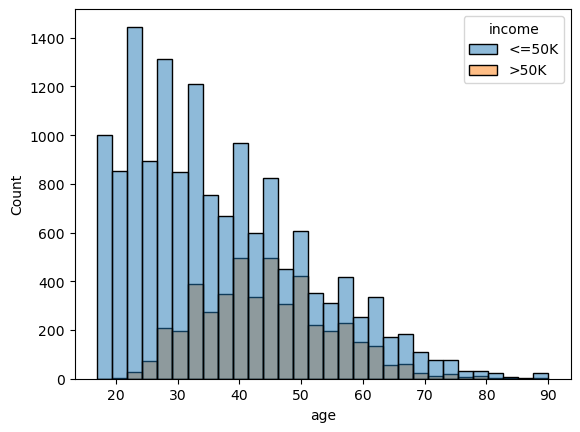

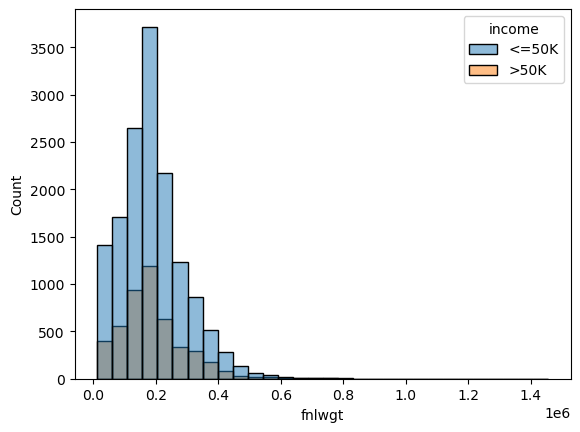

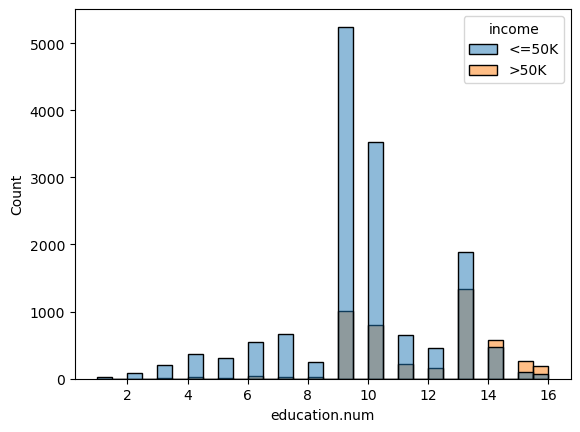

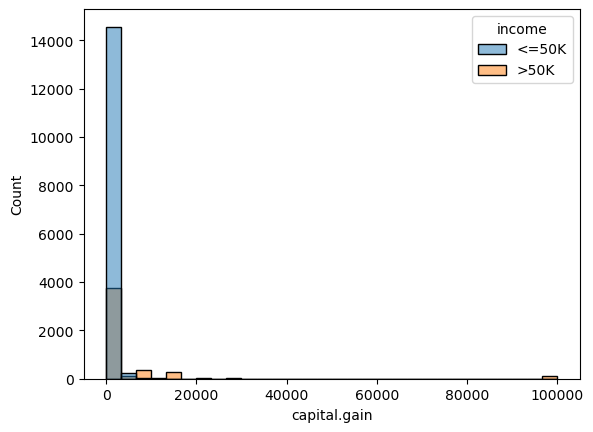

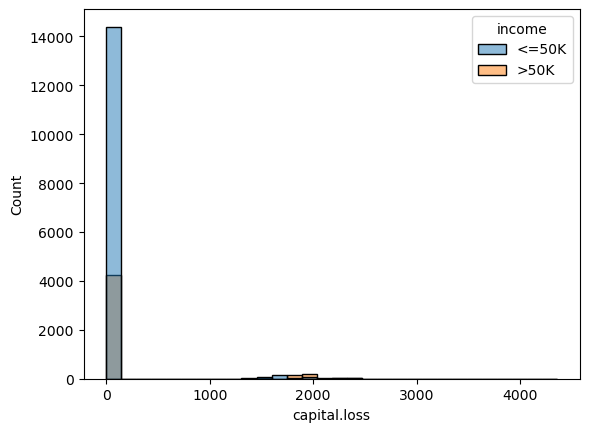

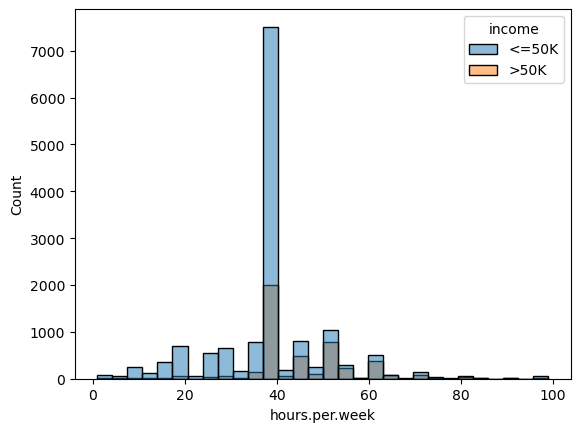

In [14]:

# train_df.hist(figsize=(10, 10),bins=20)
for c in numeric_columns:
    sns.histplot(data=train_df_nan,x=c,hue='income',bins=30)
#     sns.histplot(data=train_df_nan[train_df_nan.income == '>50K'],x=c)
    plt.show()

<br><br>

### 2.2 Identify transformations to apply
rubric={points:18}

**Your tasks:**
1. Identify the sequence of transformations that you would apply on each column in the dataset and fill in the table below accordingly. An example of the sequence of transformations to be applied on the `occupation` feature is shown in the table below. You may decide not to apply any transformations on a certain column or entirely drop a column from your model. That's totally fine. 
2. Are there common transformations you would like to apply on certain types of features? Identify different feature types for applying different transformations. In particular, fill in the lists below. 
3. Is including the `race` feature for predicting income ethically a good idea? Briefly discuss. 

> Note: This question is a bit open-ended and there is no single correct solution.

| Feature | Transformation |
| --- | ----------- |
| occupation | imputation, OHE |
| age | imputation,scaling |
| workclass | imputation,OHE |
| fnlwgt | imputation,scaling |
| education | imputation ,ordinal |
| education.num | imputation , scaling  |
| marital.status | imputation,OHE |
| relationship | imputation,OHE |
| race | imputation,OHE |
| sex | imputation,OHE |
| capital.gain | imputation,scaling |
| capital.loss | imputation,scaling |
| hours.per.week | imputation,scaling |
| native.country | imputation,OHE |



In [15]:
train_df.tail(5)
# train_df.education.unique()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
5390,51,Private,146767,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
860,55,Federal-gov,238192,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,1887,40,United-States,>50K
15795,41,Private,154076,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,>50K
23654,22,Private,162667,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,50,Portugal,<=50K


<br><br>

### 2.3 Separating feature vectors and targets  
rubric={points:4}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not?

In [16]:
x_train,y_train = train_df_nan.drop(columns='income') , train_df_nan['income']

x_test,y_test = test_df.drop(columns='income') , test_df['income']

In [17]:
x_train.head(2)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States


In [18]:
# we need to pass numerical value to SVM classifier but In above example we can see more columns have string values so
# that svm could not differentiate them.


# example                     
# mdl = SVC(gamma=0.5)
# mdl.fit(x_train,y_train) 

# vals = cross_val_score(mdl,x_train,y_train,cv=5)


<br><br><br><br>

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`
rubric={points:18}

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Note that you can define pipelines in two ways: 
- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly you can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

You may use the method of your choice but `make_pipeline` and `make_column_transformer` are highly recommended.  

**Your tasks:**

1. Create a column transformer `preprocessor` based on transformations you want to apply on the data from 2.2. 
2. Transform the data by calling `fit_transform` on the training set. What's the shape of the transformed data? 
3. Why do we need to use a column transformer in this case? Briefly explain. 

In [19]:
categorical_columns  = ['education','education.num','workclass','marital.status','occupation','race','native.country']
numeric_columns = ['age','fnlwgt','capital.gain','capital.loss','hours.per.week']
binary_columns   = ['sex']
drop_columns = []
target = ['income']

In [20]:
# from sklear.impute import Im
# using pipeline

combine_transformer = make_column_transformer(
   ( make_pipeline(SimpleImputer(strategy='median'),StandardScaler()) , numeric_columns ),
   ( make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False,handle_unknown='ignore') ) , categorical_columns )
)



# t_x_data = combine_transformer.fit_transform(x_train)

# columns = numeric_columns +  combine_transformer.named_transformers_['pipeline-2'].get_feature_names_out().tolist()

# x_train_transformed_df = pd.DataFrame(t_x_data,columns=columns)

# x_train_transformed_df.shape


##### Why do we need to use a column transformer in this case? Briefly explain.?

In exercise 2.2 we have seen that every column need diffrent transfromer based on data type like. numeric columns need imputation and 
scaling and categorical columns need imputation and OHE.

so that we can do Tranformation in two ways 
1. using pipline 
2. using column_transformer

but we need saperate tranformer to diffrent column . if we use pipeline then it is harder to do . beacuse pipline can't allow 
column wise tranformation but column-tranformation allowed.

<br><br><br><br>

## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Feel free to use it to keep track of your results if you like. 

In [21]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    
    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 
rubric={points:6}

**Your tasks:**
1. Define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict` above. Display the results as a pandas DataFrame.  

> You may use the function `mean_std_cross_val_scores` above to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [22]:
result_dict = {}
pipe = make_pipeline(combine_transformer,DummyClassifier(strategy='prior'))

result_dict['dummy'] = mean_std_cross_val_scores(pipe,x_train,y_train,cv=5)

pd.DataFrame(result_dict)

,dummy
fit_time,0.088 (+/- 0.013)
score_time,0.026 (+/- 0.008)
test_score,0.760 (+/- 0.000)


<br><br>

### 4.2 Trying different classifiers
rubric={points:14}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store the results in `results_dict`. 
2. Display all the results so far as a pandas dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?  

> Note that this might take a while to run.

> You may use the function above `mean_std_cross_val_scores` to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [23]:
models = {
    
    'Dummy' : DummyClassifier(strategy='prior'),
    'Knn' : KNeighborsClassifier(n_neighbors=5),
    'DicisionTree' : DecisionTreeClassifier(max_depth=5),
    'SVC' : SVC(),
    
}

In [24]:
Result_dict = {}
for m in models:  
    pipe = make_pipeline(combine_transformer,models[m])  
    Result_dict[m]=mean_std_cross_val_scores(pipe,x_train,y_train,cv=5)

pd.DataFrame(Result_dict).T
 

C:\Users\JENIL\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JENIL\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

,fit_time,score_time,test_score
Dummy,0.078 (+/- 0.005),0.021 (+/- 0.007),0.760 (+/- 0.000)
Knn,0.111 (+/- 0.012),0.629 (+/- 0.037),0.829 (+/- 0.008)
DicisionTree,32.139 (+/- 0.367),0.024 (+/- 0.008),0.844 (+/- 0.007)
SVC,16.504 (+/- 2.075),3.959 (+/- 0.533),0.853 (+/- 0.006)


<br><br>

### (optional) 4.3 Exploring importance of scaling
rubric={points:1}

In this exercise you'll examine whether scaling helps in case of KNNs and SVM RBFs. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results of scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not?

In [25]:
models_1 = {
    'knn' : KNeighborsClassifier(),
    'svc-rbf':SVC()
}

In [26]:
# without Sccaling
w_ct = make_column_transformer(
   ( make_pipeline(SimpleImputer(strategy='median')) , numeric_columns ),
   ( make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(sparse=False,handle_unknown='ignore') ) , categorical_columns )
)

R_dict = {
}

for i in models_1:
    w_pipe = make_pipeline(w_ct,models_1[i])
    R_dict[i]=mean_std_cross_val_scores(w_pipe,x_train,y_train,cv=5)

print("Without Scaling")
pd.DataFrame(R_dict).T

C:\Users\JENIL\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JENIL\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

Without Scaling


,fit_time,score_time,test_score
knn,0.107 (+/- 0.008),0.592 (+/- 0.020),0.773 (+/- 0.003)
svc-rbf,20.738 (+/- 0.799),5.686 (+/- 0.395),0.789 (+/- 0.001)


In [28]:
# with scaling
Result_dict = {}
for m in models_1:  
    w_pipe = make_pipeline(combine_transformer,models_1[m])  
    Result_dict[m]=mean_std_cross_val_scores(w_pipe,x_train,y_train,cv=5)

print("with scaling")
pd.DataFrame(Result_dict).T
 

C:\Users\JENIL\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JENIL\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

with scaling


,fit_time,score_time,test_score
knn,0.101 (+/- 0.004),0.596 (+/- 0.016),0.829 (+/- 0.008)
svc-rbf,16.940 (+/- 0.716),4.066 (+/- 0.212),0.853 (+/- 0.006)


### 4.4 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter: `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.1 and `SVC` classifier with the value of `C`.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best? Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this might take a while. 

In [29]:
c_values = [ 0.1,1]

R_dict = {}

for i in c_values:
    pipe = make_pipeline(combine_transformer,SVC(kernel='rbf',C=i))
    R_dict[i]=mean_std_cross_val_scores(pipe,x_train,y_train,cv=3,return_train_score=True)
    
pd.DataFrame(R_dict).T

,fit_time,score_time,test_score,train_score
0.1,12.198 (+/- 0.754),6.782 (+/- 0.116),0.848 (+/- 0.007),0.853 (+/- 0.001)
1.0,11.095 (+/- 0.194),5.807 (+/- 0.348),0.853 (+/- 0.002),0.869 (+/- 0.001)


<p> 
 From above experiments I can conclude the Best Performing model would be SVC.
 In SVC I choose kernel 'RBF' and hyperparameter C
 value of C = 0.1 
</p>  

<br><br><br><br>

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={points:10}

**Your tasks:**

1. Train the best performing model on the entire training set. 
2. Report the results of this model on `X_test`. 
3. Are the cross-validation results and test results consistent? 

In [ ]:
final_pipe = make_pipeline(combine_transformer,SVC(kernel='rbf',C=0.1))

final_pipe.fit(x_train,y_train)

print("Test Score :- ",final_pipe.score(x_test,y_test))


Trainig and testing accuracy

| Train Score | Validation Score | Test Score |
| ---         |---               | ---        |
|   0.852     | 0.848            | 0.849      |

<br><br><br><br>

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done :clap:! 

![](eva-well-done.png)

